In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [106]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
dataset = pd.concat([train, test], ignore_index = True)
passenger_id = test['PassengerId']
print(train.size, test.size)
print(dataset.isnull().sum())

10692 4598
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [88]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [107]:
# 欠損値を埋める
fare_median=dataset[(dataset['Embarked'] == "S") & (dataset['Pclass'] == 3)].Fare.median()
dataset['Fare'] = dataset['Fare'].fillna(fare_median)
dataset["Embarked"].fillna("C", inplace=True)
dataset['Cabin'] = dataset['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
dataset['Deck'] = dataset['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

In [108]:
dataset['Farebin']=pd.cut(dataset['Fare'], 5)
dataset[['Farebin','Survived']].groupby(['Farebin'],as_index=False).mean()

,Farebin,Survived
0,"(-0.512, 102.466]",0.361575
1,"(102.466, 204.932]",0.757576
2,"(204.932, 307.398]",0.647059
3,"(307.398, 409.863]",NaN
4,"(409.863, 512.329]",1.000000


In [109]:
# Fareをbinning
dataset.loc[dataset['Fare']<102.0,'Fare'] = 0
dataset.loc[(dataset['Fare']>102.0) & (dataset['Fare']<204),'Fare'] = 1
dataset.loc[(dataset['Fare']>204.0) & (dataset['Fare']<307),'Fare'] = 2
dataset.loc[dataset['Fare']>307.0, 'Fare'] = 3

In [110]:
# encoding
dataset['Embarked']=dataset['Embarked'].map({'S':1,'C':2,'Q':3})
dataset['Sex']=dataset['Sex'].map({'male':0,'female':1})

females: 0.74
males: 0.19


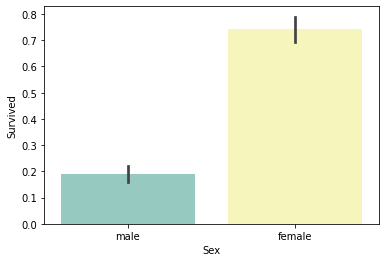

In [92]:
# 年齢と生存率のグラフ
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')

# 性別ごとの生存率
print("females: %.2f" %(train['Survived'][train['Sex'] == 'female'].value_counts(normalize = True)[1]))
print("males: %.2f" %(train['Survived'][train['Sex'] == 'male'].value_counts(normalize = True)[1]))


Pclass = 1 : 0.63
Pclass = 2 : 0.47
Pclass = 3 : 0.24


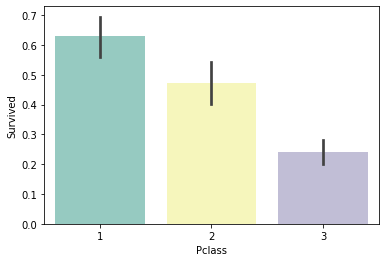

In [38]:
sns.barplot(x='Pclass', y='Survived', data=train, palette='Set3')

# チケットクラスごとの生存率
print("Pclass = 1 : %.2f" %(train['Survived'][train['Pclass']==1].value_counts(normalize = True)[1]))
print("Pclass = 2 : %.2f" %(train['Survived'][train['Pclass']==2].value_counts(normalize = True)[1]))
print("Pclass = 3 : %.2f" %(train['Survived'][train['Pclass']==3].value_counts(normalize = True)[1]))

<AxesSubplot:xlabel='Title', ylabel='Survived'>

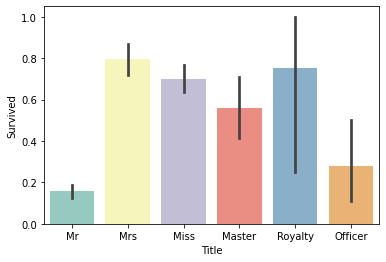

In [111]:
# 'Title'(敬称)による特徴別に分ける
dataset['Title'] = dataset['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #敬称(','と'.'の間の単語)を抽出

# 敬称をグループ分け
# 例：'Capt', 'Col', 'Major', 'Dr', 'Rev'は'Officer'とする
honorifics_dict = {}
honorifics_dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
honorifics_dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
honorifics_dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
honorifics_dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
honorifics_dict.update(dict.fromkeys(['Mr'], 'Mr'))
honorifics_dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
dataset['Title'] = dataset['Title'].map(honorifics_dict)
sns.barplot(x='Title', y='Survived', data=dataset, palette='Set3')


In [112]:
pd.crosstab(dataset.Title, dataset.Survived)

Survived,0.0,1.0
Title,,
Master,18,23
Miss,55,129
Mr,436,81
Mrs,26,101
Officer,13,5
Royalty,1,3


In [113]:
age = dataset[['Age','Pclass','Sex','Title']]
age_dummies = pd.get_dummies(age)

known_age = age_dummies[age_dummies.Age.notnull()].values
null_age = age_dummies[age_dummies.Age.isnull()].values

age_X = known_age[:, 1:]
age_y = known_age[:, 0]

if len(null_age) > 0:
# 年齢予測モデルを作成し、予測した値で年齢の欠損値を埋める
    age_rfr = RandomForestRegressor(
        n_estimators=50, criterion='mse', min_samples_split=8,
        min_samples_leaf=8, max_features=4, min_weight_fraction_leaf=0.05
    )
    age_rfr.fit(age_X, age_y)
    pred_age = age_rfr.predict(null_age[:, 1:])
    dataset.loc[(dataset.Age.isnull()),'Age'] = pred_age

dataset_null = dataset.fillna(np.nan)
print(dataset.isnull().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Deck             0
Farebin          0
Title            0
dtype: int64


In [114]:
dataset['AgeBin']=pd.cut(dataset['Age'],5)
dataset[['AgeBin','Survived']].groupby(['AgeBin'],as_index=False).mean()

,AgeBin,Survived
0,"(0.0902, 16.136]",0.548077
1,"(16.136, 32.102]",0.336735
2,"(32.102, 48.068]",0.410138
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [115]:
# Ageをbinning
dataset.loc[dataset['Age']<16.5,'Age'] = 0
dataset.loc[(dataset['Age']>16.5) & (dataset['Age']<32.5),'Age'] = 1
dataset.loc[(dataset['Age']>32.5) & (dataset['Age']<48.5),'Age'] = 2
dataset.loc[(dataset['Age']>48.5) & (dataset['Age']<64),'Age'] = 3
dataset.loc[dataset['Age']>64,'Age'] = 4

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

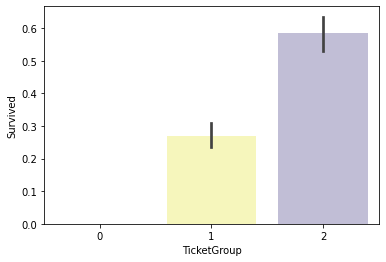

In [116]:
# チケットの文字数による生存率比較
Ticket_Count = dict(dataset['Ticket'].value_counts()) # チケットの文字数でグループ分け
dataset['TicketGroup'] = dataset['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け
#sns.barplot(x='TicketGroup', y='Survived', data=dataset, palette='Set3')

def Ticket_Label(s):
    if (s >= 2) & (s <= 4): # 文字数での生存率が高いグループ
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1): # 文字数での生存率が低いグループ
        return 1
    elif (s > 8):
        return 0

dataset['TicketGroup'] = dataset['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=dataset, palette='Set3')

<AxesSubplot:xlabel='FamilyLabel', ylabel='Survived'>

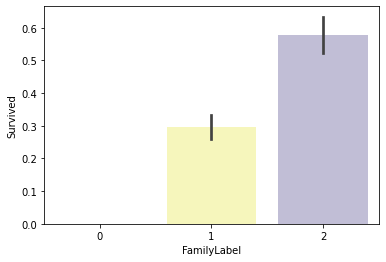

In [117]:
# 同乗している家族の数
dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

# 家族数による生存率でグループ分け
def Family_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
dataset['FamilyLabel']=dataset['FamilySize'].apply(Family_label)
sns.barplot(x="FamilyLabel", y="Survived", data=dataset, palette='Set3')

In [123]:
# NameからSurname(苗字)を抽出
dataset['Surname'] = dataset['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
dataset['FamilyGroup'] = dataset['Surname'].map(dataset['Surname'].value_counts()) 
# 家族で16才以下または女性の生存率
female_child_group=dataset.loc[(dataset['FamilyGroup']>=2) & ((dataset['Age']<=1) | (dataset['Sex']==1))]
female_child_group=female_child_group.groupby('Surname')['Survived'].mean()
print(female_child_group.value_counts())

# 家族で16才超えかつ男性の生存率
male_adult_group=dataset.loc[(dataset['FamilyGroup']>=2) & (dataset['Age']>1) & (dataset['Sex']==0)]
male_adult_list=male_adult_group.groupby('Surname')['Survived'].mean()
print(male_adult_list.value_counts())

1.000000    92
0.000000    75
0.500000    19
0.333333     6
0.666667     5
0.750000     3
0.250000     1
Name: Survived, dtype: int64
0.0    56
1.0    12
0.5     3
Name: Survived, dtype: int64


In [124]:
dead_list=set(female_child_group[female_child_group.apply(lambda x:x==0)].index)
survived_list=set(male_adult_list[male_adult_list.apply(lambda x:x==1)].index)

print('Dead_list = ', dead_list)
print('Survived_list = ', survived_list)

dataset.loc[(dataset['Survived'].isnull()) & (dataset['Surname'].apply(lambda x:x in dead_list)),
             ['Sex','Age','Title']] = [0,1,'Mr']
dataset.loc[(dataset['Survived'].isnull()) & (dataset['Surname'].apply(lambda x:x in survived_list)),
             ['Sex','Age','Title']] = [1,1,'Mrs']

Dead_list =  {'Van Impe', 'Flynn', 'Carrau', 'Goodwin', 'Olsson', 'Sage', 'Cor', 'Bryhl', 'Elias', 'del Carlo', 'Braund', 'Ilmakangas', 'Robins', 'Klasen', 'Johnston', 'Carlsson', 'Caram', 'Larsson', 'Lennon', 'Marvin', 'Moore', 'Rice', 'Zabour', 'Davidson', 'Betros', 'McNamee', 'Attalah', 'Dennis', 'Boulos', 'Kiernan', 'Rosblom', 'Ryan', 'Hickman', 'Jensen', 'Oreskovic', 'Karlsson', 'Strom', 'Andrew', 'Kink', 'Svensson', 'White', 'Barbara', 'Hagland', 'Vander Planke', 'Widener', 'Olsen', 'Samaan', 'Wiklund', 'Coleff', 'Risien', 'Calic', "O'Connor", 'Lobb', 'Johansson', 'Skoog', 'Bowen', 'Panula', 'Hansen', 'Arnold-Franchi', 'Rogers', 'Ali', 'Chronopoulos', 'Ford', 'Canavan', 'Palsson', 'Giles', 'Petroff', 'Gustafsson', 'Cacic', 'Lefebre', 'Lahtinen', 'Bourke', 'Saad', 'Turpin', 'Danbom'}
Survived_list =  {'Taylor', 'Flynn', 'Cardeza', 'Daly', 'Kimball', 'Duff Gordon', 'Frauenthal', 'Beckwith', 'Goldenberg', 'Harper', 'Bradley', 'Frolicher-Stehli'}


In [125]:
# 特徴選択
features = dataset[['Survived','Pclass','Sex','Age','Fare','Embarked','Deck','TicketGroup','Title','FamilyLabel']]

# One-hot
dataset_dummies = pd.get_dummies(features, drop_first=False)
print(dataset_dummies.head(3))

train_set = dataset_dummies[dataset_dummies['Survived'].notnull()]
test_set = dataset_dummies[dataset_dummies['Survived'].isnull()]
del test_set["Survived"]

X = train_set.values[:, 1:] # Pclass以降の変数
y = train_set.values[:, 0] # 正解データ


   Survived  Pclass  Sex  Age  Fare  Embarked  TicketGroup  FamilyLabel  \
0       0.0       3    0  1.0   0.0         1            1            2   
1       1.0       1    1  2.0   0.0         2            2            2   
2       1.0       3    1  1.0   0.0         1            1            1   

   Deck_A  Deck_B  ...  Deck_F  Deck_G  Deck_T  Deck_U  Title_Master  \
0       0       0  ...       0       0       0       1             0   
1       0       0  ...       0       0       0       0             0   
2       0       0  ...       0       0       0       1             0   

   Title_Miss  Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  
0           0         1          0              0              0  
1           0         0          1              0              0  
2           1         0          0              0              0  

[3 rows x 23 columns]


In [126]:
# モデルの作成
rfc = RandomForestClassifier(
    random_state = 10,
    max_features='sqrt',
)

param_grid = {'n_estimators':list(range(20, 150, 10)),
              'max_depth':list(range(3, 10, 1))}
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_, sep="\n")
#{'classify__max_depth': 6, 'classify__n_estimators': 20}
#0.8462421972534331


{'max_depth': 8, 'n_estimators': 120}
0.8395255930087391


In [127]:
select = SelectKBest(k=20)
rfc = RandomForestClassifier(
    random_state = 10,
    warm_start = True,
    max_features='sqrt',
    max_depth=8,
    n_estimators=120
)
pipeline = make_pipeline(select, rfc)
pipeline.fit(X, y)
cv_result = model_selection.cross_validate(pipeline, X, y, cv=10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

mean_score =  0.8417727840199751
mean_std =  0.03557610853733699


In [131]:
xgb = XGBClassifier(random_state = 10, use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')
param_grid = {
    'n_estimators':list(range(50, 150, 10)),
    'learning_rate':[0.08, 0.1, 0.12],
    'max_depth':list(range(3, 10, 1)),
}
grid = GridSearchCV(estimator = xgb, param_grid = param_grid, n_jobs=1, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_, sep="\n")
#{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 140}
#0.8485393258426965

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60}
0.837278401997503


In [134]:
select = SelectKBest(k=18)
clf = XGBClassifier(
    random_state = 10,
    objective='binary:logistic',
    n_estimators=60,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)
cv_result = model_selection.cross_validate(pipeline, X, y, cv=10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))


mean_score =  0.8327715355805243
mean_std =  0.0374161802224643


In [135]:
mask= select.get_support()

list_col = list(dataset_dummies.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 Pclass = True
No2 Sex = True
No3 Age = True
No4 Fare = True
No5 Embarked = True
No6 TicketGroup = True
No7 FamilyLabel = True
No8 Deck_A = False
No9 Deck_B = True
No10 Deck_C = True
No11 Deck_D = True
No12 Deck_E = True
No13 Deck_F = True
No14 Deck_G = False
No15 Deck_T = False
No16 Deck_U = True
No17 Title_Master = True
No18 Title_Miss = True
No19 Title_Mr = True
No20 Title_Mrs = True
No21 Title_Officer = False
No22 Title_Royalty = True
X.shape=(891, 22), X_selected.shape=(891, 18)


In [136]:
pred = pipeline.predict(test_set)
#pred = grid.predict(test_set)

In [137]:
submission = pd.DataFrame({"PassengerId": passenger_id, "Survived": pred.astype(np.int32)})
submission.to_csv("submission.csv", index=False)